In [2]:
import numpy as np
import math
import scipy as sp
from scipy.io.wavfile import write
import sounddevice as sd
import matplotlib.pyplot as plt 
%matplotlib inline 

def morse(text, file_name=None, SNR_dB=20, f_code=600, Fs=8000, code_speed=20, length_N=None, play_sound=True):
    '''
    # MORSE converts text to playable morse code in wav format
    #
    # SYNTAX
    # morse(text)
    # morse(text,file_name),
    # morse(text,file_name,SNR_dB),
    # morse(text, file_name,SNR_dB,code_frequency),
    # morse(text, file_name,SNR_dB,code_frequency,sample_rate),
    # morse(text, file_name,SNR_dB,code_frequency,sample_rate, code_speed_wpm, zero_fill_to_N),
    # morse(text, file_name,SNR_dB,code_frequency,sample_rate, code_speed_wpm, zero_fill_to_N, play_sound),
    #
    # Description:
    #
    #   If the wave file name is specified, then the funtion will output a wav
    #   file with that file name.  If only text is specified, then the function
    #   will only play the morse code wav file without saving it to a wav file.
    #   If a snr is specified, zero mean addative white Gaussian
    #   noise is added
    #
    # Examples:
    #
    #   morse('Hello'),
    #   morse('How are you doing my friend?','morsecode.wav'),
    #   morse('How are you doing my friend?','morsecode.wav', 20),
    #   morse('How are you doing my friend?','morsecode.wav', 10, 440,Fs,20),
    #   x = morse('How are you doing my friend?','morsecode.wav', 3, 440,Fs, 20, 2^20,True), #(to play the file, and make the length 2^20)
    #
    #   Copyright 2018 Mauri Niininen, AG1LE
    '''


    #t = 0:1/Fs:1.2/code_speed,  #One dit of time at w wpm is 1.2/w.

    t = np.linspace(0., 1.2/code_speed, num=int(Fs*1.2/code_speed), endpoint=True, retstep=False)
   
    Dit = np.sin(2*np.pi*f_code*t)
    ssp = np.zeros(len(Dit))
    # one Dah of time is 3 times  dit time
    t2 = np.linspace(0., 3*1.2/code_speed, num=3*int(Fs*1.2/code_speed), endpoint=True, retstep=False)
    #Dah = np.concatenate((Dit,Dit,Dit))
    Dah = np.sin(2*np.pi*f_code*t2)
    
    lsp = np.zeros(len(Dah)),    # changed size argument to function of Dah 

    # Defining Characters & Numbers
    Codebook = {
        "A": np.concatenate((Dit,ssp,Dah)),
        "B": np.concatenate((Dah,ssp,Dit,ssp,Dit,ssp,Dit)),
        "C": np.concatenate((Dah,ssp,Dit,ssp,Dah,ssp,Dit)),
        "D": np.concatenate((Dah,ssp,Dit,ssp,Dit)),
        "E": Dit,
        "F": np.concatenate((Dit,ssp,Dit,ssp,Dah,ssp,Dit)),
        "G": np.concatenate((Dah,ssp,Dah,ssp,Dit)),
        "H": np.concatenate((Dit,ssp,Dit,ssp,Dit,ssp,Dit)),
        "I": np.concatenate((Dit,ssp,Dit)),
        "J": np.concatenate((Dit,ssp,Dah,ssp,Dah,ssp,Dah)),
        "K": np.concatenate((Dah,ssp,Dit,ssp,Dah)),
        "L": np.concatenate((Dit,ssp,Dah,ssp,Dit,ssp,Dit)),
        "M": np.concatenate((Dah,ssp,Dah)),
        "N": np.concatenate((Dah,ssp,Dit)),
        "O": np.concatenate((Dah,ssp,Dah,ssp,Dah)),
        "P": np.concatenate((Dit,ssp,Dah,ssp,Dah,ssp,Dit)),
        "Q": np.concatenate((Dah,ssp,Dah,ssp,Dit,ssp,Dah)),
        "R": np.concatenate((Dit,ssp,Dah,ssp,Dit)),
        "S": np.concatenate((Dit,ssp,Dit,ssp,Dit)),
        "T": Dah,
        "U": np.concatenate((Dit,ssp,Dit,ssp,Dah)),
        "V": np.concatenate((Dit,ssp,Dit,ssp,Dit,ssp,Dah)),
        "W": np.concatenate((Dit,ssp,Dah,ssp,Dah)),
        "X": np.concatenate((Dah,ssp,Dit,ssp,Dit,ssp,Dah)),
        "Y": np.concatenate((Dah,ssp,Dit,ssp,Dah,ssp,Dah)),
        "Z": np.concatenate((Dah,ssp,Dah,ssp,Dit,ssp,Dit)),
        ".": np.concatenate((Dit,ssp,Dah,ssp,Dit,ssp,Dah,ssp,Dit,ssp,Dah)),
        ",": np.concatenate((Dah,ssp,Dah,ssp,Dit,ssp,Dit,ssp,Dah,ssp,Dah)),
        "?": np.concatenate((Dit,ssp,Dit,ssp,Dah,ssp,Dah,ssp,Dit,ssp,Dit)),
        "/": np.concatenate((Dah,ssp,Dit,ssp,Dit,ssp,Dah,ssp,Dit)),
        "1": np.concatenate((Dit,ssp,Dah,ssp,Dah,ssp,Dah,ssp,Dah)),
        "2": np.concatenate((Dit,ssp,Dit,ssp,Dah,ssp,Dah,ssp,Dah)),
        "3": np.concatenate((Dit,ssp,Dit,ssp,Dit,ssp,Dah,ssp,Dah)),
        "4": np.concatenate((Dit,ssp,Dit,ssp,Dit,ssp,Dit,ssp,Dah)),
        "5": np.concatenate((Dit,ssp,Dit,ssp,Dit,ssp,Dit,ssp,Dit)),
        "6": np.concatenate((Dah,ssp,Dit,ssp,Dit,ssp,Dit,ssp,Dit)),
        "7": np.concatenate((Dah,ssp,Dah,ssp,Dit,ssp,Dit,ssp,Dit)),
        "8": np.concatenate((Dah,ssp,Dah,ssp,Dah,ssp,Dit,ssp,Dit)),
        "9": np.concatenate((Dah,ssp,Dah,ssp,Dah,ssp,Dah,ssp,Dit)),
        "0": np.concatenate((Dah,ssp,Dah,ssp,Dah,ssp,Dah,ssp,Dah)),
      }
    text = text.upper()

    # start with pause (7 dit lengths)
    morsecode= np.concatenate((ssp,ssp,ssp,ssp,ssp,ssp,ssp))
    for ch in text:
        if ch == ' ':
            morsecode = np.concatenate((morsecode, ssp,ssp,ssp,ssp))
        elif ch == '\n':
            pass
        else:
            val = Codebook[ch]
            morsecode = np.concatenate((morsecode, val, ssp,ssp,ssp))
        
    #morsecode = np.concatenate((morsecode, lsp))

    if length_N:
        append_length = length_N - len(morsecode)
        if (append_length < 0):
            print("Length {} isn't large enough for your message, it must be > {}.\n".format(length_N,len(morsecode)))
            return morsecode
        else:
            morsecode = np.concatenate((morsecode, np.zeros(append_length,1)))
        
    # end with pause (14 dit lengths)
    morsecode = np.concatenate((morsecode,ssp,ssp,ssp,ssp,ssp,ssp,ssp,ssp,ssp,ssp,ssp,ssp,ssp,ssp))

    #noise = randn(size(morsecode)), 
    #[noisy,noise] = addnoise(morsecode,noise,snr),
    
    if SNR_dB:
        # https://stackoverflow.com/questions/52913749/add-random-noise-with-specific-snr-to-a-signal
        # Desired SNR in dB

        # Desired linear SNR
        SNR_linear = 10.0**(SNR_dB/10.0)
        #print( "Linear snr = ", SNR_linear)

        # Measure power of signal - assume zero mean 
        power = morsecode.var()
        #print ("Power of signal = ", power)

        # Calculate required noise power for desired SNR
        noise_power = power/SNR_linear
        #print ("Noise power = ", noise_power )
        #print ("Calculated SNR = {:4.2f} dB".format(10*np.log10(power/noise_power )))

        # Generate noise with calculated power (mu=0, sigma=1)
        noise = np.sqrt(noise_power)*np.random.normal(0,1,len(morsecode))

        # Add noise to signal
        morsecode = noise + morsecode

    # Normalize before saving 
    max_n = max(morsecode),
    morsecode = morsecode/max_n
    
    if file_name:
        write(file_name, Fs, morsecode)
    if play_sound:
        sd.play(morsecode, Fs)
    return morsecode
    

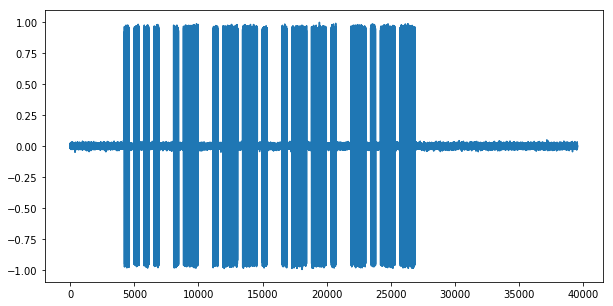

In [15]:
# morse(text, file_name,snr=20,f_code=600,Fs=8000, code_speed=20, length_N=None, play_sound=False):
x = morse(" HAPPY    ", "happy.wav", 30,600,8000, 25, None, True)
plt.figure(figsize=[10,5])
plt.plot(x)

In [ ]:
# http://www.random.org/strings/?num=300&len=20&digits=on&upperalpha=on&loweralpha=off&unique=on&format=plain&rnd=new
import requests

In [23]:
# retrieve 400 random strings (length 20) and generate text/ audio/ morse files from each line
# store file names into 'morsewords.txt' text file for Morse-CNN-RNN-CTC training sessions


import requests 
URL = "https://www.random.org/strings/?num=400&len=20&digits=on&upperalpha=on&loweralpha=off&unique=on&format=plain&rnd=new"

code_speed =30
SNR_DB = 40 

rv = requests.get(URL)
if rv.status_code == 200:
    with open('morsewords.txt','w') as mf:
        for line in rv.text.split("\n"):
            if len(line) > 10:
                print(line)

                txt_file = 'text/'+line+".txt"
                audio_file = 'audio/'+line+".wav"
                with open(txt_file,"w") as f:
                    f.write(line)
                morse(line, audio_file, SNR_DB,600,8000, code_speed, None, False)
                mf.write(txt_file+' '+audio_file+' '+line+'\n')
print("Completed {} files".format(len(rv.text.split("\n"))))
        
        

4ANO0P8U1YEBGD28393D
('Linear snr = ', 10000.0)
('Power of signal = ', 0.27036441029900338)
('Noise power = ', 2.7036441029900337e-05)
Calculated SNR = 40.00 dB
TPG62IVMQ37URPLK0105
('Linear snr = ', 10000.0)
('Power of signal = ', 0.26569385593220352)
('Noise power = ', 2.656938559322035e-05)
Calculated SNR = 40.00 dB
UHSKMNTTJ1TQDRCSTZL4
('Linear snr = ', 10000.0)
('Power of signal = ', 0.24433016877637134)
('Noise power = ', 2.4433016877637134e-05)
Calculated SNR = 40.00 dB
1LU1IJXR6UD75VI4T7XK
('Linear snr = ', 10000.0)
('Power of signal = ', 0.24864506457564581)
('Noise power = ', 2.4864506457564581e-05)
Calculated SNR = 40.00 dB
Q29CJQJDUEASD0ZC93Z9
('Linear snr = ', 10000.0)
('Power of signal = ', 0.27485240228013041)
('Noise power = ', 2.7485240228013041e-05)
Calculated SNR = 40.00 dB
FPT5PJBENGI5X3MUKHJM
('Linear snr = ', 10000.0)
('Power of signal = ', 0.24249746963562757)
('Noise power = ', 2.4249746963562758e-05)
Calculated SNR = 40.00 dB
VZF09U60WAAEP59ANM0V
('Linear snr =

('Linear snr = ', 10000.0)
('Power of signal = ', 0.24670138888888893)
('Noise power = ', 2.4670138888888894e-05)
Calculated SNR = 40.00 dB
EU6CH2RO9JD2Q6QHZ2U5
('Linear snr = ', 10000.0)
('Power of signal = ', 0.25735834775086508)
('Noise power = ', 2.5735834775086509e-05)
Calculated SNR = 40.00 dB
70UJRVJQ3JFGV4K1SZ7J
('Linear snr = ', 10000.0)
('Power of signal = ', 0.26831738599348548)
('Noise power = ', 2.6831738599348546e-05)
Calculated SNR = 40.00 dB
W7RKM8Q91W57FNB7PL9D
('Linear snr = ', 10000.0)
('Power of signal = ', 0.26547345317725757)
('Noise power = ', 2.6547345317725757e-05)
Calculated SNR = 40.00 dB
TPH8KQKQ8WQN1GH8AZ47
('Linear snr = ', 10000.0)
('Power of signal = ', 0.26592031786941589)
('Noise power = ', 2.6592031786941588e-05)
Calculated SNR = 40.00 dB
I184BAWKE08UHJ75LT3C
('Linear snr = ', 10000.0)
('Power of signal = ', 0.25585237455197141)
('Noise power = ', 2.558523745519714e-05)
Calculated SNR = 40.00 dB
O1N3UZG5K81N721F8RTE
('Linear snr = ', 10000.0)
('Power 

COS8WKYJO1D2XJQT7OQS
('Linear snr = ', 10000.0)
('Power of signal = ', 0.27553825250836128)
('Noise power = ', 2.7553825250836128e-05)
Calculated SNR = 40.00 dB
IAEV5GA91LDOKUYLX5TV
('Linear snr = ', 10000.0)
('Power of signal = ', 0.24662178853754949)
('Noise power = ', 2.4662178853754949e-05)
Calculated SNR = 40.00 dB
9AQURA2JHYZHTTLXHK2A
('Linear snr = ', 10000.0)
('Power of signal = ', 0.25434885931558937)
('Noise power = ', 2.5434885931558936e-05)
Calculated SNR = 40.00 dB
9GPM2QVFAZI8S5KUJZQR
('Linear snr = ', 10000.0)
('Power of signal = ', 0.25944780465949829)
('Noise power = ', 2.5944780465949831e-05)
Calculated SNR = 40.00 dB
GJM9UK8RHYONQIZGZ69A
('Linear snr = ', 10000.0)
('Power of signal = ', 0.26651467971530257)
('Noise power = ', 2.6651467971530257e-05)
Calculated SNR = 40.00 dB
4WVFLOP44X23UTAXT8PE
('Linear snr = ', 10000.0)
('Power of signal = ', 0.25051498127340827)
('Noise power = ', 2.5051498127340826e-05)
Calculated SNR = 40.00 dB
5DR8XWP91GQ13ZQ8CRFH
('Linear snr 

WI7GU6X968HFKDBMV2O8
('Linear snr = ', 10000.0)
('Power of signal = ', 0.25747258771929832)
('Noise power = ', 2.5747258771929831e-05)
Calculated SNR = 40.00 dB
YS5OZW7UIM3LTBFDRZZ3
('Linear snr = ', 10000.0)
('Power of signal = ', 0.24670138888888898)
('Noise power = ', 2.4670138888888898e-05)
Calculated SNR = 40.00 dB
I1RFD87YPTID8NZT1PAC
('Linear snr = ', 10000.0)
('Power of signal = ', 0.25802902621722856)
('Noise power = ', 2.5802902621722856e-05)
Calculated SNR = 40.00 dB
4R1OIGMZ6IDUK10OLNL2
('Linear snr = ', 10000.0)
('Power of signal = ', 0.26304323476702518)
('Noise power = ', 2.6304323476702517e-05)
Calculated SNR = 40.00 dB
G73C1SK2C0T8EL5O5RM6
('Linear snr = ', 10000.0)
('Power of signal = ', 0.25923245614035095)
('Noise power = ', 2.5923245614035094e-05)
Calculated SNR = 40.00 dB
4YK13UXY57MFV0EOVQST
('Linear snr = ', 10000.0)
('Power of signal = ', 0.26107553003533579)
('Noise power = ', 2.610755300353358e-05)
Calculated SNR = 40.00 dB
RP0M5EGRMPIH0UZWJPQT
('Linear snr =

WF1ELH009C5RXDYW5L6T
('Linear snr = ', 10000.0)
('Power of signal = ', 0.25916267421602796)
('Noise power = ', 2.5916267421602797e-05)
Calculated SNR = 40.00 dB
YCCAJRKQBEOZ1QSOAUN3
('Linear snr = ', 10000.0)
('Power of signal = ', 0.26345133763837647)
('Noise power = ', 2.6345133763837645e-05)
Calculated SNR = 40.00 dB
FY0BR7LGAZYZPFQD4IOT
('Linear snr = ', 10000.0)
('Power of signal = ', 0.25952166064981952)
('Noise power = ', 2.5952166064981951e-05)
Calculated SNR = 40.00 dB
IX8KPH0XY3BS5A3ROL97
('Linear snr = ', 10000.0)
('Power of signal = ', 0.25902598797250864)
('Noise power = ', 2.5902598797250865e-05)
Calculated SNR = 40.00 dB
15HT3BKWYY7JG83O3V86
('Linear snr = ', 10000.0)
('Power of signal = ', 0.26515368852459026)
('Noise power = ', 2.6515368852459026e-05)
Calculated SNR = 40.00 dB
YHSQ5X6WU06Y5M3P3OC3
('Linear snr = ', 10000.0)
('Power of signal = ', 0.258827861952862)
('Noise power = ', 2.5882786195286201e-05)
Calculated SNR = 40.00 dB
63U4XLN5CEE85P8YDY1P
('Linear snr = 

11HP7ZWZEQ5OX8LYYN4L
('Linear snr = ', 10000.0)
('Power of signal = ', 0.26389414983164988)
('Noise power = ', 2.6389414983164989e-05)
Calculated SNR = 40.00 dB
QSQDESSI92MENXM7XJG2
('Linear snr = ', 10000.0)
('Power of signal = ', 0.25446862840466933)
('Noise power = ', 2.5446862840466932e-05)
Calculated SNR = 40.00 dB
MY5YP81LANFC3PVC3C9U
('Linear snr = ', 10000.0)
('Power of signal = ', 0.26389414983164988)
('Noise power = ', 2.6389414983164989e-05)
Calculated SNR = 40.00 dB
C29D9JM8AY8EA5OF3CCM
('Linear snr = ', 10000.0)
('Power of signal = ', 0.26922994880546086)
('Noise power = ', 2.6922994880546087e-05)
Calculated SNR = 40.00 dB
A6CPDOEMSH7LDLTNY5C4
('Linear snr = ', 10000.0)
('Power of signal = ', 0.23843623481781381)
('Noise power = ', 2.3843623481781383e-05)
Calculated SNR = 40.00 dB
Y8QYFTNY18NRQC97NGSE
('Linear snr = ', 10000.0)
('Power of signal = ', 0.2681647526501767)
('Noise power = ', 2.6816475265017671e-05)
Calculated SNR = 40.00 dB
GGTN6G2AWS8IC1DPYH7G
('Linear snr =

1MGAZ9Z4UD95BEJNRD88
('Linear snr = ', 10000.0)
('Power of signal = ', 0.2611599199288257)
('Noise power = ', 2.6115991992882569e-05)
Calculated SNR = 40.00 dB
0RY8QITT1IFT5YH98V9B
('Linear snr = ', 10000.0)
('Power of signal = ', 0.2645120614035088)
('Noise power = ', 2.6451206140350881e-05)
Calculated SNR = 40.00 dB
YAY6HYDJMFAQBJM1Z4JD
('Linear snr = ', 10000.0)
('Power of signal = ', 0.26451206140350886)
('Noise power = ', 2.6451206140350884e-05)
Calculated SNR = 40.00 dB
CD9MU3O2MXY1SWTMTT6G
('Linear snr = ', 10000.0)
('Power of signal = ', 0.26554307116104875)
('Noise power = ', 2.6554307116104876e-05)
Calculated SNR = 40.00 dB
ZKR2IHFF4D8H5JWLLGWN
('Linear snr = ', 10000.0)
('Power of signal = ', 0.24290636882129282)
('Noise power = ', 2.4290636882129282e-05)
Calculated SNR = 40.00 dB
SWS57RFK08GIQEGVLABD
('Linear snr = ', 10000.0)
('Power of signal = ', 0.24467524509803926)
('Noise power = ', 2.4467524509803925e-05)
Calculated SNR = 40.00 dB
1QF1W8KXMS0V0NBVEF5A
('Linear snr = 

HAZUFHWO75C7SPIQM40B
('Linear snr = ', 10000.0)
('Power of signal = ', 0.24864506457564584)
('Noise power = ', 2.4864506457564584e-05)
Calculated SNR = 40.00 dB
NV0WAMVG5KGFXXBKEUAE
('Linear snr = ', 10000.0)
('Power of signal = ', 0.24651491769547335)
('Noise power = ', 2.4651491769547334e-05)
Calculated SNR = 40.00 dB
M7YV3Q7VQ1XRVWLGLQIG
('Linear snr = ', 10000.0)
('Power of signal = ', 0.26256487889273367)
('Noise power = ', 2.6256487889273365e-05)
Calculated SNR = 40.00 dB
Q0CALRQKSTWPQ4HONI5C
('Linear snr = ', 10000.0)
('Power of signal = ', 0.25431014150943398)
('Noise power = ', 2.5431014150943398e-05)
Calculated SNR = 40.00 dB
08LY6Y3842J99LHLH2RH
('Linear snr = ', 10000.0)
('Power of signal = ', 0.26737132352941179)
('Noise power = ', 2.673713235294118e-05)
Calculated SNR = 40.00 dB
RNRWCAV0O7V4PM8XLNVQ
('Linear snr = ', 10000.0)
('Power of signal = ', 0.25952166064981952)
('Noise power = ', 2.5952166064981951e-05)
Calculated SNR = 40.00 dB
AIK9PXOWHTG2E86YR3M0
('Linear snr =

In [41]:
# 24487 words in alphabetical order 
# https://svnweb.freebsd.org/csrg/share/dict/words?view=co&content-type=text/plain 
#

import requests
import random
import uuid
import re


URL = "https://svnweb.freebsd.org/csrg/share/dict/words?view=co&content-type=text/plain"
code_speed =30
SNR_DB = 40 
count = 400
word_max_length = 5
words_in_sample = 2

rv = requests.get(URL)
if rv.status_code == 200:
    with open('morsewords.txt','w') as mf:
        words = rv.text.split("\n")
        wordcount = len(words)
        words = [w.upper() for w in words if len(w) <= word_max_length]
        for i in range(count):
            audio_file = "audio/"+uuid.uuid4().hex+".wav"
            sample= random.sample(words, words_in_sample)
            phrase = re.sub(r'\W+', '', ' '.join(sample))            
            morse(phrase, audio_file, SNR_DB,600,8000, code_speed, None, False)
            mf.write(audio_file+' '+phrase+'\n')
            print(audio_file,phrase)
        print("completed {} files".format(count)) 



('Linear snr = ', 10000.0)
('Power of signal = ', 0.23371371722846451)
('Noise power = ', 2.337137172284645e-05)
Calculated SNR = 40.00 dB
('audio/3c96620eb1c641bcb5dfbcbc6b793e65.wav', u'BORN GAUZY MOCK LURE DUSK')
('Linear snr = ', 10000.0)
('Power of signal = ', 0.21476593625498014)
('Noise power = ', 2.1476593625498013e-05)
Calculated SNR = 40.00 dB
('audio/7080ea2b1f964049a6214752d5de7819.wav', u'FETUS ZEBRA LOON ENEMY SUDS')
('Linear snr = ', 10000.0)
('Power of signal = ', 0.2267430278884463)
('Noise power = ', 2.2674302788844629e-05)
Calculated SNR = 40.00 dB
('audio/ac989b29a8c04563847cc7c8b1897ec2.wav', u'PURE AUK ALOFT GAUNT DAMON')
('Linear snr = ', 10000.0)
('Power of signal = ', 0.21390564671814677)
('Noise power = ', 2.1390564671814678e-05)
Calculated SNR = 40.00 dB
('audio/d81b0720f98d4fc1a928479cb36f597e.wav', u'FIRST GORKY NATAL SHADE SPIT')
('Linear snr = ', 10000.0)
('Power of signal = ', 0.19839984939759037)
('Noise power = ', 1.9839984939759036e-05)
Calculated SNR

('audio/1fbf0b20c4914e17bdce743f1f411769.wav', u'IDIOT GREEN MOST CRONE NOV')
('Linear snr = ', 10000.0)
('Power of signal = ', 0.22296813241106728)
('Noise power = ', 2.2296813241106728e-05)
Calculated SNR = 40.00 dB
('audio/d7fd0c64b9334d1789c9f42304c9bf0f.wav', u'MOOD INDO VERGE MINOS THREW')
('Linear snr = ', 10000.0)
('Power of signal = ', 0.191918834841629)
('Noise power = ', 1.9191883484162899e-05)
Calculated SNR = 40.00 dB
('audio/3205f093f7e6408784df78be9fa01e86.wav', u'SIAN HEAP SIMON ASHER DAIS')
('Linear snr = ', 10000.0)
('Power of signal = ', 0.20957115800865805)
('Noise power = ', 2.0957115800865807e-05)
Calculated SNR = 40.00 dB
('audio/9a03a18a820d4e508f872184d560dbe1.wav', u'TUNG RUB SHAWL HUGE PACE')
('Linear snr = ', 10000.0)
('Power of signal = ', 0.2339656365313654)
('Noise power = ', 2.3396563653136539e-05)
Calculated SNR = 40.00 dB
('audio/29466250e7fb475784e3d563b4febc66.wav', u'IGLOO ARGOT DEWAR DEPOT ICC')
('Linear snr = ', 10000.0)
('Power of signal = ', 0.2

('Linear snr = ', 10000.0)
('Power of signal = ', 0.23170400943396235)
('Noise power = ', 2.3170400943396234e-05)
Calculated SNR = 40.00 dB
('audio/fd713a3782c0408ebbbddd8a2992e853.wav', u'HURRY GUS AMEN GOOD HAPPY')
('Linear snr = ', 10000.0)
('Power of signal = ', 0.21922794117647063)
('Noise power = ', 2.1922794117647062e-05)
Calculated SNR = 40.00 dB
('audio/91955f27c9334039a8b2f534fca87146.wav', u'PACT PION SHOE CLOSE BLEND')
('Linear snr = ', 10000.0)
('Power of signal = ', 0.22317401960784319)
('Noise power = ', 2.2317401960784319e-05)
Calculated SNR = 40.00 dB
('audio/cbb10ebf2673481583c30e55982e397a.wav', u'HOMO GENOA KELP EERIE GLOVE')
('Linear snr = ', 10000.0)
('Power of signal = ', 0.2450778388278389)
('Noise power = ', 2.450778388278389e-05)
Calculated SNR = 40.00 dB
('audio/81557f5bab2245d9ab7be5cf3c5185de.wav', u'FOOT ARABY OVUM MAE PYGMY')
('Linear snr = ', 10000.0)
('Power of signal = ', 0.22337670233463039)
('Noise power = ', 2.2337670233463039e-05)
Calculated SNR = 

('audio/8ee7f3ec267b4726bde30dc7f6bc0344.wav', u'RIFLE JURA SETUP COMB SISAL')
('Linear snr = ', 10000.0)
('Power of signal = ', 0.21444272813688217)
('Noise power = ', 2.1444272813688219e-05)
Calculated SNR = 40.00 dB
('audio/829c7364175a4bb3964258cef575760d.wav', u'CERES SPECK PABST RADON BATH')
('Linear snr = ', 10000.0)
('Power of signal = ', 0.20386590375586858)
('Noise power = ', 2.0386590375586858e-05)
Calculated SNR = 40.00 dB
('audio/8f811aa0d1264a05adc4d3a8017836b9.wav', u'OAT SILK FLAKE TEAL DEAD')
('Linear snr = ', 10000.0)
('Power of signal = ', 0.20151115023474181)
('Noise power = ', 2.0151115023474182e-05)
Calculated SNR = 40.00 dB
('audio/52b96b2a3ac64208b0f4349aa5ccae0d.wav', u'DHABI KORAN AH WEEK HATE')
('Linear snr = ', 10000.0)
('Power of signal = ', 0.19963414634146348)
('Noise power = ', 1.9963414634146348e-05)
Calculated SNR = 40.00 dB
('audio/cd3a7fafeb924d1baa24dc7e91aea24a.wav', u'REBEL CRAW AZ SLATE RAE')
('Linear snr = ', 10000.0)
('Power of signal = ', 0.22

('audio/84d046a73c394ec5b66ecf000ec83130.wav', u'CO DEGUM HEIGH BOOBY HIKE')
('Linear snr = ', 10000.0)
('Power of signal = ', 0.19109821428571436)
('Noise power = ', 1.9109821428571436e-05)
Calculated SNR = 40.00 dB
('audio/f45e102908a4462da56e6c691b04541a.wav', u'THIS GIN MOE BEAT NAN')
('Linear snr = ', 10000.0)
('Power of signal = ', 0.22316176470588245)
('Noise power = ', 2.2316176470588245e-05)
Calculated SNR = 40.00 dB
('audio/6412d63b236b4d7e8e6c704093222d8d.wav', u'CHUCK PEDRO MEAD OTIS ALGA')
('Linear snr = ', 10000.0)
('Power of signal = ', 0.21174242424242429)
('Noise power = ', 2.1174242424242428e-05)
Calculated SNR = 40.00 dB
('audio/a7e7831c786746548d1a80b121842408.wav', u'CAGE KIVU LICE BLEAK BAG')
('Linear snr = ', 10000.0)
('Power of signal = ', 0.21970318532818536)
('Noise power = ', 2.1970318532818535e-05)
Calculated SNR = 40.00 dB
('audio/c5566dd776fc4c31a7614e6751c76eb0.wav', u'EROS LLAMA CHEWY RINK ROSEN')
('Linear snr = ', 10000.0)
('Power of signal = ', 0.21061

('audio/f97fdca71c9644c0a2b547c118c46f55.wav', u'SNAIL GOOSE HASH BLAT LEGGY')
('Linear snr = ', 10000.0)
('Power of signal = ', 0.22454112453531602)
('Noise power = ', 2.2454112453531603e-05)
Calculated SNR = 40.00 dB
('audio/d63db306396e424692aebc4f5318132f.wav', u'DIRTY NOISY RAZE OKAPI INDEX')
('Linear snr = ', 10000.0)
('Power of signal = ', 0.22229251012145754)
('Noise power = ', 2.2229251012145755e-05)
Calculated SNR = 40.00 dB
('audio/5abe95884087418da27472cf97ffeac8.wav', u'HAYDN VOSS IAN POOR SLUG')
('Linear snr = ', 10000.0)
('Power of signal = ', 0.21658608490566042)
('Noise power = ', 2.1658608490566041e-05)
Calculated SNR = 40.00 dB
('audio/ce7a8fbd1e49409f9e8c6b5fcf70346e.wav', u'BOMB FILET GREEK PLUSH BOIL')
('Linear snr = ', 10000.0)
('Power of signal = ', 0.21969111969111974)
('Noise power = ', 2.1969111969111973e-05)
Calculated SNR = 40.00 dB
('audio/6a8735e7acc549309e58a6dd6a5fad45.wav', u'SNAG YELP DRAPE PALL RUNIC')
('Linear snr = ', 10000.0)
('Power of signal = '

('audio/ca931e923a054b54a50fa7f3a4a610af.wav', u'SCALY VOLE CAFE UNITE SHAG')
('Linear snr = ', 10000.0)
('Power of signal = ', 0.22370331950207473)
('Noise power = ', 2.2370331950207472e-05)
Calculated SNR = 40.00 dB
('audio/4d58d64c519044a29458cb9af6b29895.wav', u'GOURD CLAM DUST CAPER CT')
('Linear snr = ', 10000.0)
('Power of signal = ', 0.1977053140096619)
('Noise power = ', 1.9770531400966191e-05)
Calculated SNR = 40.00 dB
('audio/d8fc66d9b06b4233bde5325e2281af78.wav', u'GAVE TEA RICE JERES RAUL')
('Linear snr = ', 10000.0)
('Power of signal = ', 0.22525383574007224)
('Noise power = ', 2.2525383574007225e-05)
Calculated SNR = 40.00 dB
('audio/2008c501e254494a9488e83e0a2ceecd.wav', u'DUGAN SPLIT BORAX TABU SWAMP')
('Linear snr = ', 10000.0)
('Power of signal = ', 0.23963636363636373)
('Noise power = ', 2.3963636363636374e-05)
Calculated SNR = 40.00 dB
('audio/9b663c55eb1d45b798fab4b3e815ffa3.wav', u'GAUZY BOUGH PLOT INK LOON')
('Linear snr = ', 10000.0)
('Power of signal = ', 0.21

('audio/e2c2825bf4c54965b8d0b472a7cf26fc.wav', u'DEAR RING MORAN RHO GUANO')
('Linear snr = ', 10000.0)
('Power of signal = ', 0.22622308052434464)
('Noise power = ', 2.2622308052434464e-05)
Calculated SNR = 40.00 dB
('audio/957f8b4640a0487abf4a49f562fe5d33.wav', u'BATHE QUID MEEK LAYUP GUNKY')
('Linear snr = ', 10000.0)
('Power of signal = ', 0.21550110132158601)
('Noise power = ', 2.15501101321586e-05)
Calculated SNR = 40.00 dB
('audio/66a26bc95f1240a4ad214fbd33d91e7f.wav', u'NEED ALMA TAFT FLOYD BIG')
('Linear snr = ', 10000.0)
('Power of signal = ', 0.22097332015810281)
('Noise power = ', 2.209733201581028e-05)
Calculated SNR = 40.00 dB
('audio/8285b11604a14f4bb502fdd439b833d1.wav', u'PAMPA RUNNY HASP ARAB AUNT')
('Linear snr = ', 10000.0)
('Power of signal = ', 0.20054223744292243)
('Noise power = ', 2.0054223744292243e-05)
Calculated SNR = 40.00 dB
('audio/e28f02e0234247c8923c27747ad17122.wav', u'LIEN UTTER CO RUBIN ILIAD')
('Linear snr = ', 10000.0)
('Power of signal = ', 0.2160

('audio/28231622d8894f5a85d3ea2a9d51112d.wav', u'MILK BEGET GABON TUFT MALAY')
('Linear snr = ', 10000.0)
('Power of signal = ', 0.20010800691244246)
('Noise power = ', 2.0010800691244247e-05)
Calculated SNR = 40.00 dB
('audio/b43b092cc5af4c938ff22cd943e5760e.wav', u'SITUS DIG MOTET RIME SAULT')
('Linear snr = ', 10000.0)
('Power of signal = ', 0.20778818093385218)
('Noise power = ', 2.0778818093385217e-05)
Calculated SNR = 40.00 dB
('audio/e315b33148cd4b92a0efd0d2f945cb0b.wav', u'THANK ETHIC SPIRE MISTY IDAHO')
('Linear snr = ', 10000.0)
('Power of signal = ', 0.23674828178694166)
('Noise power = ', 2.3674828178694166e-05)
Calculated SNR = 40.00 dB
('audio/773877ae1fe64ea795b126c65b583ad0.wav', u'BLANC CRAMP CODA JERRY MANNA')
('Linear snr = ', 10000.0)
('Power of signal = ', 0.21167923151750978)
('Noise power = ', 2.1167923151750978e-05)
Calculated SNR = 40.00 dB
('audio/13e880f5a14848d6a24c4dab5eb10c57.wav', u'GRIND NASH REEDY CRUEL SIMON')
('Linear snr = ', 10000.0)
('Power of sign

('audio/4b4d5e5e3dfb41fa80fc366377a3103f.wav', u'SIAN SILO POLO AUGER PURSE')
completed 400 files


In [45]:
from os import listdir
from os.path import isfile, join
experiments = [f for f in listdir("audio/") if isfile(join("audio/", f))]
#    for filename in experiments:
#        print(filename)

In [46]:
experiments

['helloworld.wav',
 '17ab9fa6bf2b43ccbcd136480290e0b3.wav',
 'eb6edf656c0d49ffb21549af1ccfa81a.wav',
 '4abf9b055b334bf2aa88dc28e050994b.wav',
 '70b2b83d28bd49b08893386c4070ea5c.wav',
 'b52865bd70654740bfa646e2094f07df.wav',
 '89249693a71040bb96dbcb4e8c3281b5.wav',
 '42374faaedf64da9a12f09961bf64327.wav',
 '73e5edcabf1643ee9e08752847425a2c.wav',
 'e6c6040483164fe3aca7c569f55e12e8.wav',
 '9631c7f0c0794e7aabe3867f47d74020.wav',
 '7567f3e86cab4647b1e8237ec5a3fe35.wav',
 '6f0a8fd667ea4f60992e2cc97283f809.wav',
 '0cce04dee95844569cd2478d0672f45b.wav',
 '6c8ab208981840699ebc4cefdd767c10.wav',
 '69f8fa676ca94c47b1fcade55a0055b0.wav',
 '1b9bc6cb0b8d4d30845b29f01c13a475.wav',
 '87d62833a0434bb896def11555d15881.wav',
 '71578f0376fe4194b4321e5b705984e7.wav',
 '20ea4ff6161445e489db8facec55d4f4.wav',
 '14dc6c95dba044c2abf57c5225106cae.wav',
 'a865a00f4e26464891f70623a4dfff58.wav',
 'dd76317e1e964f89bac8d20bea88c723.wav',
 '5733c984bf90450aa11229c8b5a2ed8f.wav',
 '01b3e3bef62b4226b68bce6b5428028b.wav